In [1]:
import os
os.chdir("../..")

In [2]:
import torch
from utils.dataset_loader import *
from utils.model_utils import *
from utils.train_utils import *
from utils.metrics import *
from utils.visualization import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
data_dir = "wildfire_dataset_scaled"
batch_size = 32
learning_rate = 0.0008
num_classes = 2
model_name = "mobilenet_v2"
output_dir = "outputs/models/augmented"
metrics_output_dir = "outputs/plots/augmented"
os.makedirs(output_dir, exist_ok=True)


In [5]:
print("[INFO] Loading augmented datasets...")
train_loader, val_loader, test_loader = load_datasets(
    data_dir=data_dir, batch_size=batch_size, augmentation="augmented"
)
print("[INFO] Augmented datasets loaded successfully!")

2024-12-23 21:30:49,018 - INFO - Loading datasets from wildfire_dataset_scaled with augmentation type 'augmented'.
2024-12-23 21:30:49,019 - INFO - Applying selected augmentations for wildfire scenarios.
2024-12-23 21:30:49,032 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/train
2024-12-23 21:30:49,036 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/val
2024-12-23 21:30:49,039 - INFO - Initialized AlbumentationsDataset with root: wildfire_dataset_scaled/test
2024-12-23 21:30:49,040 - INFO - Datasets initialized. Preparing DataLoaders...
2024-12-23 21:30:49,041 - INFO - Using WeightedRandomSampler for class balancing.
2024-12-23 21:30:49,042 - INFO - Computing class weights from directory: wildfire_dataset_scaled/train
2024-12-23 21:30:49,045 - INFO - Class 'fire' has 730 samples.
2024-12-23 21:30:49,047 - INFO - Class 'nofire' has 1157 samples.
2024-12-23 21:30:49,048 - INFO - Computed class weights: {'fire': 1.0, 'nofire': 

[INFO] Loading augmented datasets...


2024-12-23 21:31:02,648 - INFO - DataLoaders created successfully.


[INFO] Augmented datasets loaded successfully!


In [6]:
# Initialize the model
print(f"\n[INFO] Starting Training for Model: {model_name} with Augmented Data\n")
print(f"[INFO] Initializing {model_name} model...")
model = initialize_model(
    model_name=model_name,
    num_classes=num_classes,
    pretrained=True,
    freeze_all=True  # Baseline augmentation: Freeze all layers
)
print("[INFO] Model initialized successfully!")


[INFO] Starting Training for Model: mobilenet_v2 with Augmented Data

[INFO] Initializing mobilenet_v2 model...
[INFO] Model initialized successfully!


In [7]:
# Define loss function and optimizer
print("[INFO] Setting up loss function and optimizer...")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
print("[INFO] Loss function and optimizer set up!")

[INFO] Setting up loss function and optimizer...
[INFO] Loss function and optimizer set up!


In [8]:
# Train the model

from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
print("[INFO] Starting model training with augmented data...")
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,  # No LR scheduler for augmented baseline
    device=device,
    save_path=os.path.join(output_dir, f"{model_name}_augmented.pt"),
    early_stop_patience=10,  # Early stopping patience
    monitor_metric="val_f1"
)
print("[INFO] Training completed successfully!")

[INFO] Starting model training with augmented data...

Starting training...



[INFO] Learning rate adjusted to: 0.000800
[INFO] Best model saved with val_f1: 0.8054
Epoch [1]: Train Loss: 0.5732, Train Acc: 0.7091 | Val Loss: 0.5080, Val Acc: 0.7512, Val Recall: 0.8415, Val F1: 0.8054


[INFO] Learning rate adjusted to: 0.000800
[INFO] Best model saved with val_f1: 0.8330
Epoch [2]: Train Loss: 0.4557, Train Acc: 0.8055 | Val Loss: 0.4700, Val Acc: 0.7985, Val Recall: 0.8211, Val F1: 0.8330


[INFO] Learning rate adjusted to: 0.000800
[INFO] Best model saved with val_f1: 0.8470
Epoch [3]: Train Loss: 0.4289, Train Acc: 0.7997 | Val Loss: 0.4300, Val Acc: 0.8184, Val Recall: 0.8211, Val F1: 0.8470


[INFO] Learning rate adjusted to: 0.000800
[INFO] No improvement in val_f1. Patience: 1/10
Epoch [4]: Train Loss: 0.4029, Train Acc: 0.8219 | Val Loss: 0.4082, Val Acc: 0.8085, Val Recall: 0.8293, Val F1: 0.8412


[INFO] Learning rate adjusted to: 0.000400
[INFO] Best model saved with val_f1: 0.8810
Epoch [5]: Train Loss: 0.3942, Train Acc: 0.8251 | Val Loss: 0.3824, Val Acc: 0.8507, Val Recall: 0.9024, Val F1: 0.8810


[INFO] Learning rate adjusted to: 0.000400
[INFO] No improvement in val_f1. Patience: 1/10
Epoch [6]: Train Loss: 0.3739, Train Acc: 0.8431 | Val Loss: 0.4012, Val Acc: 0.8109, Val Recall: 0.8089, Val F1: 0.8397


[INFO] Learning rate adjusted to: 0.000400
[INFO] No improvement in val_f1. Patience: 2/10
Epoch [7]: Train Loss: 0.3530, Train Acc: 0.8490 | Val Loss: 0.4101, Val Acc: 0.8308, Val Recall: 0.8740, Val F1: 0.8635


[INFO] Learning rate adjusted to: 0.000400
[INFO] No improvement in val_f1. Patience: 3/10
Epoch [8]: Train Loss: 0.3729, Train Acc: 0.8336 | Val Loss: 0.3826, Val Acc: 0.8308, Val Recall: 0.8455, Val F1: 0.8595


[INFO] Learning rate adjusted to: 0.000400
[INFO] No improvement in val_f1. Patience: 4/10
Epoch [9]: Train Loss: 0.3533, Train Acc: 0.8468 | Val Loss: 0.3816, Val Acc: 0.8483, Val Recall: 0.8821, Val F1: 0.8768


[INFO] Learning rate adjusted to: 0.000200
[INFO] No improvement in val_f1. Patience: 5/10
Epoch [10]: Train Loss: 0.3578, Train Acc: 0.8447 | Val Loss: 0.3797, Val Acc: 0.8209, Val Recall: 0.8821, Val F1: 0.8577


[INFO] Learning rate adjusted to: 0.000200
[INFO] No improvement in val_f1. Patience: 6/10
Epoch [11]: Train Loss: 0.3626, Train Acc: 0.8410 | Val Loss: 0.3648, Val Acc: 0.8408, Val Recall: 0.8699, Val F1: 0.8699


[INFO] Learning rate adjusted to: 0.000200
[INFO] No improvement in val_f1. Patience: 7/10
Epoch [12]: Train Loss: 0.3635, Train Acc: 0.8421 | Val Loss: 0.3682, Val Acc: 0.8458, Val Recall: 0.8862, Val F1: 0.8755


[INFO] Learning rate adjusted to: 0.000200
[INFO] No improvement in val_f1. Patience: 8/10
Epoch [13]: Train Loss: 0.3573, Train Acc: 0.8442 | Val Loss: 0.3773, Val Acc: 0.8333, Val Recall: 0.8659, Val F1: 0.8641


[INFO] Learning rate adjusted to: 0.000200
[INFO] No improvement in val_f1. Patience: 9/10
Epoch [14]: Train Loss: 0.3531, Train Acc: 0.8415 | Val Loss: 0.3874, Val Acc: 0.8333, Val Recall: 0.8537, Val F1: 0.8624


[INFO] Learning rate adjusted to: 0.000100
[INFO] No improvement in val_f1. Patience: 10/10
Epoch [15]: Train Loss: 0.3462, Train Acc: 0.8574 | Val Loss: 0.3733, Val Acc: 0.8358, Val Recall: 0.8537, Val F1: 0.8642
[INFO] Final metrics saved to outputs/models/augmented\final_metrics.json
[INFO] Training stopped after 15 epochs. Best val_f1: 0.8810

[INFO] Training completed successfully!


In [9]:
# Evaluate the model
print("[INFO] Evaluating the model...")
metrics = evaluate_model(
    model=model,
    test_loader=test_loader,
    classes=["No Fire", "Fire"],
    device=device,
    model_name=model_name,
    save_base_path=metrics_output_dir+f"/{model_name}_augmented"
)
print(f"\n[INFO] Metrics for {model_name} with Augmented Data:\n{metrics}")

[INFO] Evaluating the model...
[INFO] Evaluation metrics saved to outputs/plots/augmented/mobilenet_v2_augmented\mobilenet_v2\mobilenet_v2_evaluation.json

[INFO] Metrics for mobilenet_v2 with Augmented Data:
{'classification_report': {'No Fire': {'precision': 0.8070175438596491, 'recall': 0.8679245283018868, 'f1-score': 0.8363636363636363, 'support': 159.0}, 'Fire': {'precision': 0.9121338912133892, 'recall': 0.8685258964143426, 'f1-score': 0.889795918367347, 'support': 251.0}, 'accuracy': 0.8682926829268293, 'macro avg': {'precision': 0.8595757175365191, 'recall': 0.8682252123581147, 'f1-score': 0.8630797773654917, 'support': 410.0}, 'weighted avg': {'precision': 0.8713692589469388, 'recall': 0.8682926829268293, 'f1-score': 0.86907461876103, 'support': 410.0}}, 'confusion_matrix': [[138, 21], [33, 218]], 'roc_auc': 0.9348517878172843, 'y_true': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[INFO] Saving training and evaluation results...
[INFO] Training plot saved to outputs/plots/augmented\mobilenet_v2_augmented_training_curve.png
[INFO] Confusion matrix saved to outputs/plots/augmented\mobilenet_v2_augmented_confusion_matrix.png
[INFO] ROC curve saved to outputs/plots/augmented\mobilenet_v2_augmented_roc_curve.png
[INFO] Precision-Recall curve saved to outputs/plots/augmented\mobilenet_v2_augmented_precision_recall.png
[INFO] All results saved successfully!


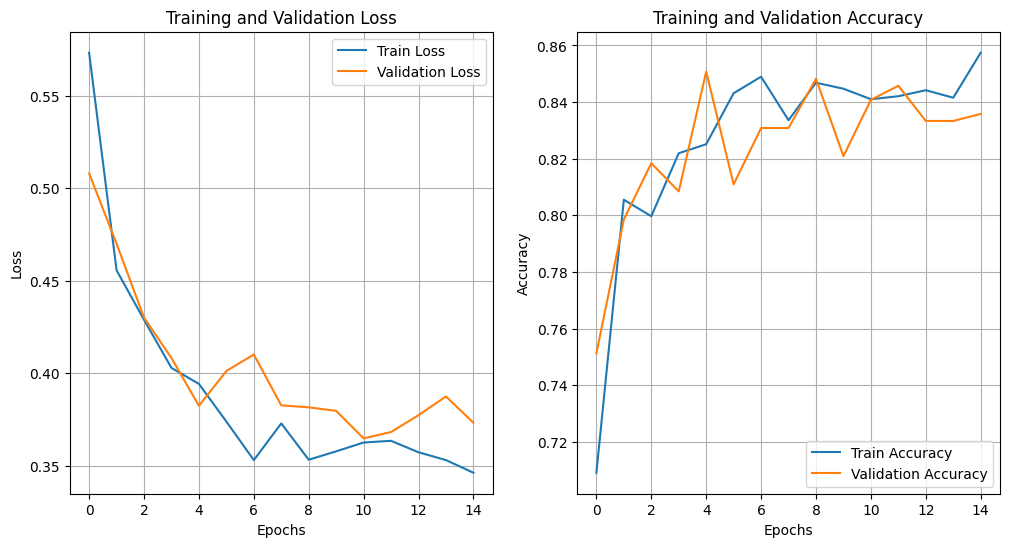

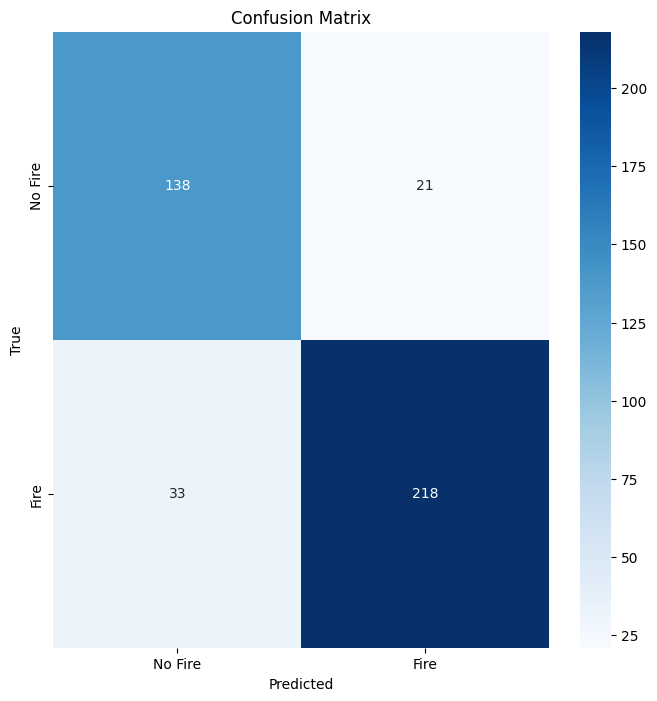

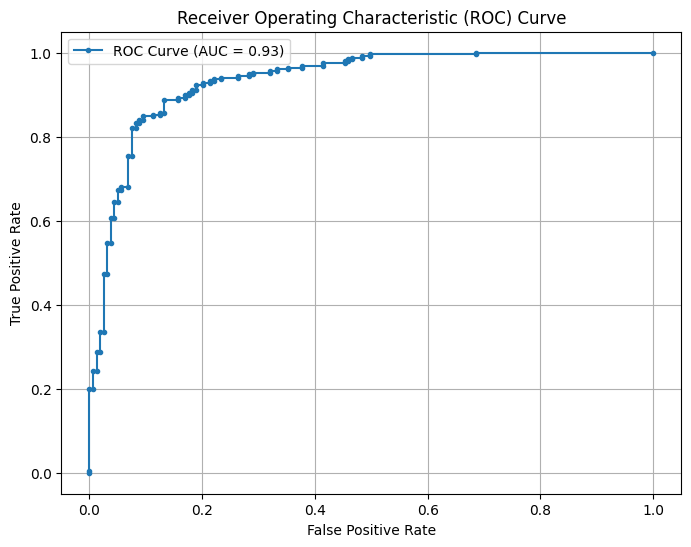

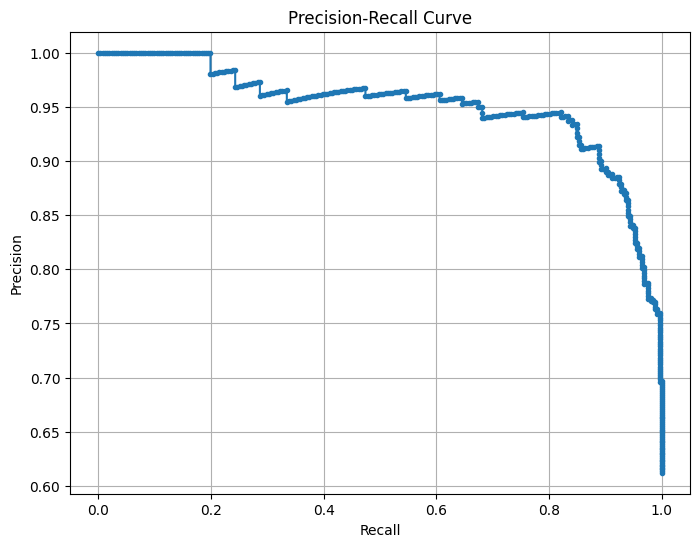

In [10]:
print("[INFO] Saving training and evaluation results...")

# Training curve
plot_training(
    history, output_path=os.path.join(metrics_output_dir, f"{model_name}_augmented_training_curve.png")
)

# Confusion matrix
plot_confusion_matrix(
    cm=metrics["confusion_matrix"],
    classes=["No Fire", "Fire"],
    output_path=os.path.join(metrics_output_dir, f"{model_name}_augmented_confusion_matrix.png")
)

# ROC Curve
plot_roc_curve(
    y_true=metrics["y_true"],
    y_scores=metrics["y_scores"],
    output_path=os.path.join(metrics_output_dir, f"{model_name}_augmented_roc_curve.png")
)

# Precision-Recall Curve
plot_precision_recall(
    y_true=metrics["y_true"],
    y_scores=metrics["y_scores"],
    output_path=os.path.join(metrics_output_dir, f"{model_name}_augmented_precision_recall.png")
)

print("[INFO] All results saved successfully!")